#Setup and preprocessing

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [3]:
!ls 

code			 norm_gap_dense.h5    tl_binary.h5
dani_binary_model.ipynb  relevant_or_not.zip  tlft13_model.h5
dani_ensamble.ipynb	 resnet_.h5	      tl_model_gap.h5
dani_model.ipynb	 salva_model.ipynb
inception_v3.h5		 submit.zip


In [4]:
!cp submit.zip /content

In [5]:
%cd /content

/content


In [6]:
# unzip at every run to have ready all images (content is cleaned at any new session)
!unzip submit.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: submit/train/wildfire/2896872.jpg  
  inflating: submit/train/wildfire/2896873.jpg  
  inflating: submit/train/wildfire/2896874.jpg  
  inflating: submit/train/wildfire/2896876.jpg  
  inflating: submit/train/wildfire/2896877.jpg  
  inflating: submit/train/wildfire/2896878.jpg  
  inflating: submit/train/wildfire/2896879.jpg  
  inflating: submit/train/wildfire/2896880.JPG  
  inflating: submit/train/wildfire/2896881.jpg  
  inflating: submit/train/wildfire/2896882.jpg  
  inflating: submit/train/wildfire/2896883.jpg  
  inflating: submit/train/wildfire/2896884.jpg  
  inflating: submit/train/wildfire/2896885.jpg  
  inflating: submit/train/wildfire/2896886.png  
  inflating: submit/train/wildfire/2896887.jpg  
  inflating: submit/train/wildfire/2896888.jpg  
  inflating: submit/train/wildfire/2896889.jpeg  
  inflating: submit/train/wildfire/2896890.jpg  
  inflating: submit/train/wildfire/2896891.jpg  
  inflating: submi

In [7]:
import os

folder_path = "submit"

# Iterate through the folders
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            os.remove(file_path)

In [18]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
# from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [10]:
# Dataset folders 
dataset_dir = '/content/submit'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
print(training_dir)
labels = ['cyclone','earthquake','flood','volcano', 'wildfire']

/content/submit/train


Text(0.5, 1.0, 'Number of training images per category:')

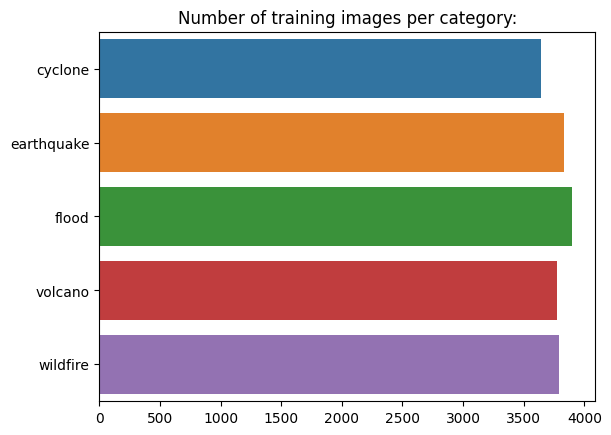

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
# Note that commets line are for here for old augmentations maybe not neccessary in future

aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        #height_shift_range=5,
                                        #width_shift_range=5,
                                        #zoom_range=0.5,
                                        #horizontal_flip=True,
                                        #vertical_flip=True, 
                                        #fill_mode='constant',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input
                                    )
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input
                                   )

In [13]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 18934 images belonging to 5 classes.
Found 3788 images belonging to 5 classes.
Found 2540 images belonging to 5 classes.


In [14]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 5)

Categorical label: [0. 0. 0. 0. 1.]
Label: 4
Class name: wildfire


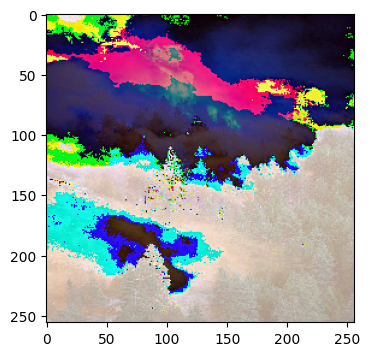

In [15]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

#Train

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
      
  callbacks = []

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Download and plot the vgg16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
input_shape = (256, 256, 3)
epochs = 20

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
# No resize
x = supernet(inputs)

x = tfkl.BatchNormalization()(x)  # Add batch normalization layer
x = tfkl.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)

x = tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.2, seed=seed)(x)

output_layer = tfkl.Dense(units=5, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         1179904   
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 256)              0     

In [ ]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'resnet50_first')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks
).history

Epoch 1/20
592/592 [==============================] - 665s 1s/step - loss: 0.3835 - accuracy: 0.8669 - precision_1: 0.8811 - recall_1: 0.8531 - val_loss: 0.2789 - val_accuracy: 0.9084 - val_precision_1: 0.9158 - val_recall_1: 0.9021
Epoch 2/20
592/592 [==============================] - 625s 1s/step - loss: 0.2547 - accuracy: 0.9117 - precision_1: 0.9213 - recall_1: 0.9036 - val_loss: 0.2381 - val_accuracy: 0.9195 - val_precision_1: 0.9288 - val_recall_1: 0.9155
Epoch 3/20
592/592 [==============================] - 629s 1s/step - loss: 0.2148 - accuracy: 0.9262 - precision_1: 0.9324 - recall_1: 0.9189 - val_loss: 0.2397 - val_accuracy: 0.9219 - val_precision_1: 0.9277 - val_recall_1: 0.9174
Epoch 4/20
592/592 [==============================] - 634s 1s/step - loss: 0.1767 - accuracy: 0.9395 - precision_1: 0.9449 - recall_1: 0.9340 - val_loss: 0.2703 - val_accuracy: 0.9142 - val_precision_1: 0.9207 - val_recall_1: 0.9108
Epoch 5/20
592/592 [==============================] - 631s 1s/step -

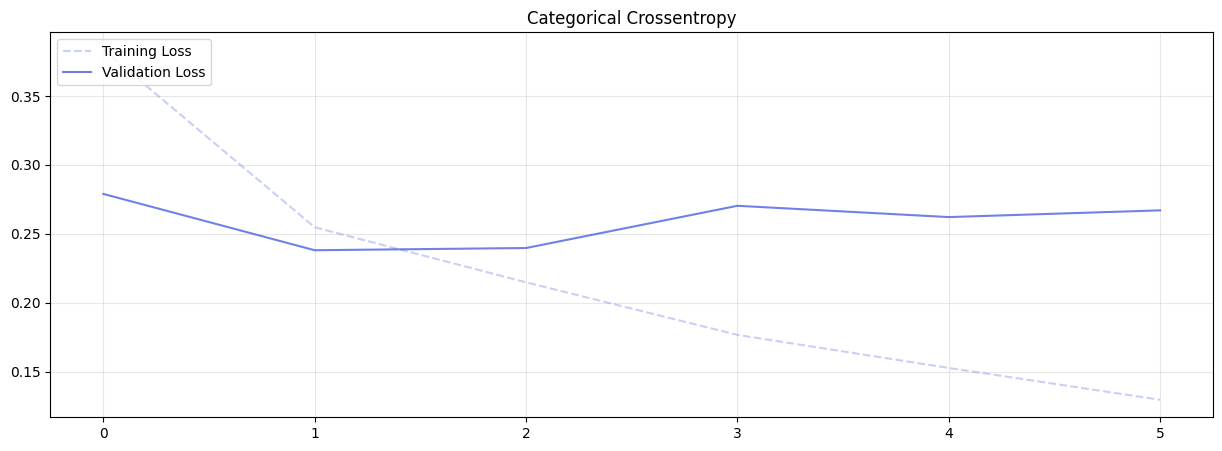

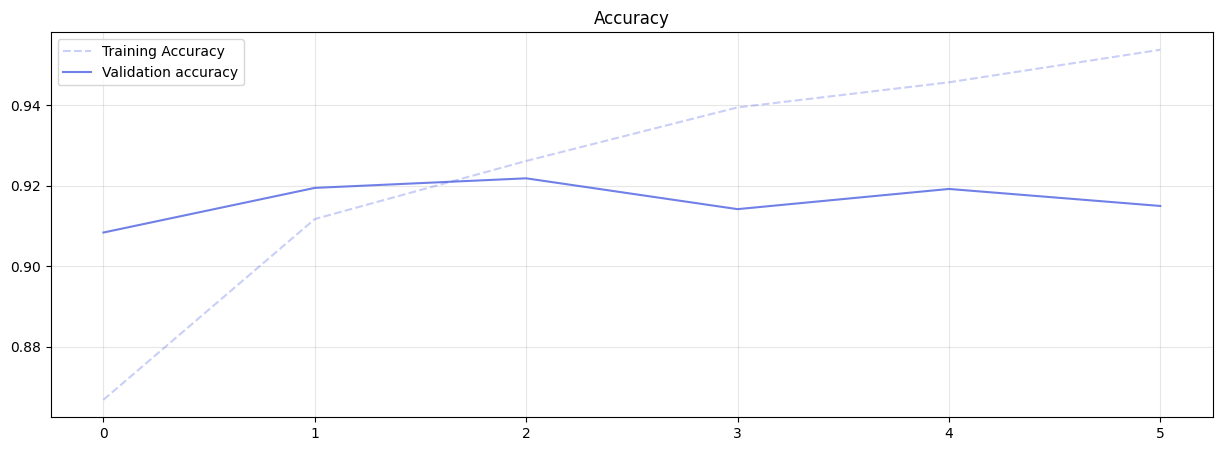

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/bis_project/'

# Define the name of the model file
model_name = 'norm_gap_dense.h5'

# Save the model to a file
tl_model.save(model_name)

# Move the model file to your Google Drive folder
shutil.copy(model_name, folder_path)

print(f'Successfully saved {model_name} to {folder_path}')


Successfully saved norm_gap_dense.h5 to /gdrive/MyDrive/bis_project/


#Load the model

In [16]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [17]:
from tensorflow.keras.models import load_model
tl_model=load_model('resnet_.h5')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Flattening (Flatten)        (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                             

# Fine Tuning

In [19]:
tl_model.get_layer('resnet50').trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [20]:
for i, layer in enumerate(tl_model.get_layer('resnet50').layers[:125]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('resnet50').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [21]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [22]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 20,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=2 , restore_best_weights=True)],
).history

Epoch 1/20
592/592 [==============================] - 687s 1s/step - loss: 0.1957 - accuracy: 0.9361 - precision: 0.9424 - recall: 0.9301 - val_loss: 0.1913 - val_accuracy: 0.9372 - val_precision: 0.9434 - val_recall: 0.9322
Epoch 2/20
592/592 [==============================] - 637s 1s/step - loss: 0.0886 - accuracy: 0.9712 - precision: 0.9731 - recall: 0.9694 - val_loss: 0.2099 - val_accuracy: 0.9390 - val_precision: 0.9431 - val_recall: 0.9361
Epoch 3/20
592/592 [==============================] - 639s 1s/step - loss: 0.0579 - accuracy: 0.9805 - precision: 0.9814 - recall: 0.9796 - val_loss: 0.2180 - val_accuracy: 0.9377 - val_precision: 0.9405 - val_recall: 0.9353
Epoch 4/20
592/592 [==============================] - 645s 1s/step - loss: 0.0508 - accuracy: 0.9834 - precision: 0.9843 - recall: 0.9825 - val_loss: 0.2133 - val_accuracy: 0.9427 - val_precision: 0.9466 - val_recall: 0.9409
Epoch 5/20
592/592 [==============================] - 641s 1s/step - loss: 0.0393 - accuracy: 0.9864

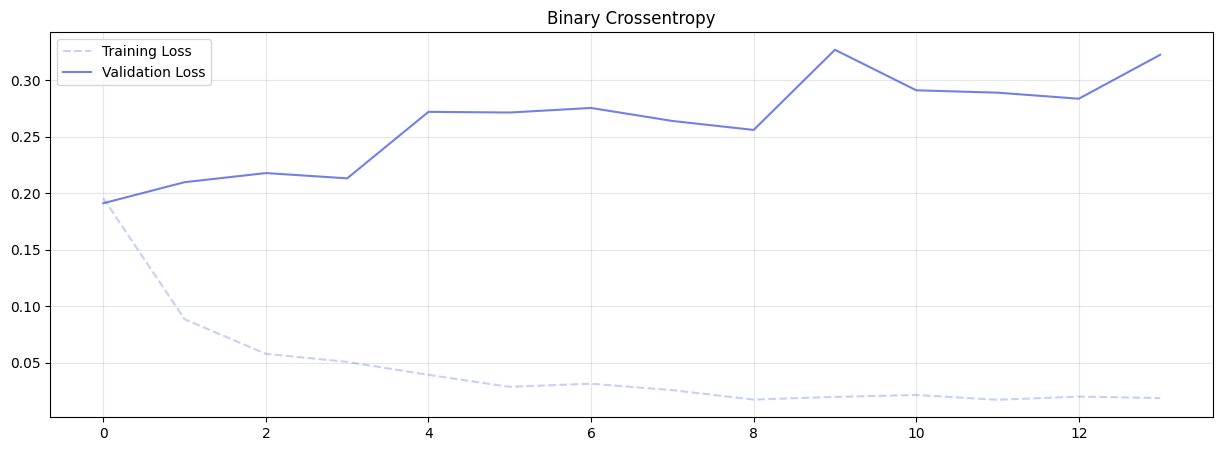

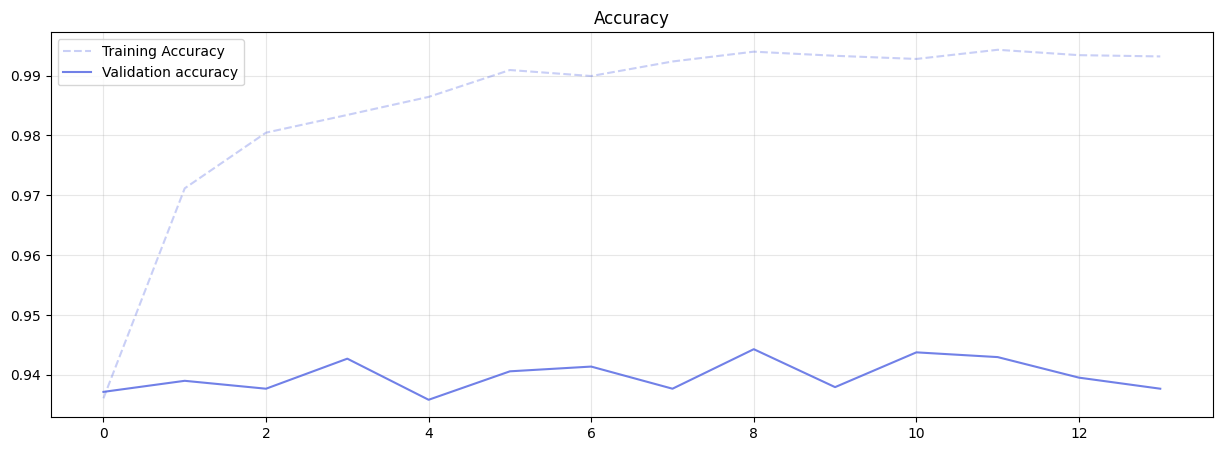

In [23]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [24]:
import shutil
# Define the folder path where you want to save the model file
folder_path = '/gdrive/MyDrive/'

# Define the name of the model file
model_name = 'ft_resnet.h5'

# Save the model to a file
tl_model.save(model_name)

# Move the model file to your Google Drive folder
shutil.copy(model_name, folder_path)

print(f'Successfully saved {model_name} to {folder_path}')

Successfully saved ft_resnet.h5 to /gdrive/MyDrive/


#Test on the test set from the generator

In [25]:
# Test the model
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

80/80 [==============================] - 71s 864ms/step - loss: 0.2141 - accuracy: 0.9496 - precision: 0.9496 - recall: 0.9496

Test metrics
{'loss': 0.21408948302268982, 'accuracy': 0.9496062994003296, 'precision': 0.9496062994003296, 'recall': 0.9496062994003296}


<ipython-input-26-3dec7973a8ca>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = tl_model.predict_generator(test_gen, steps=224)


Accuracy: 0.9496
Precision: 0.9496
Recall: 0.9492
F1: 0.9493


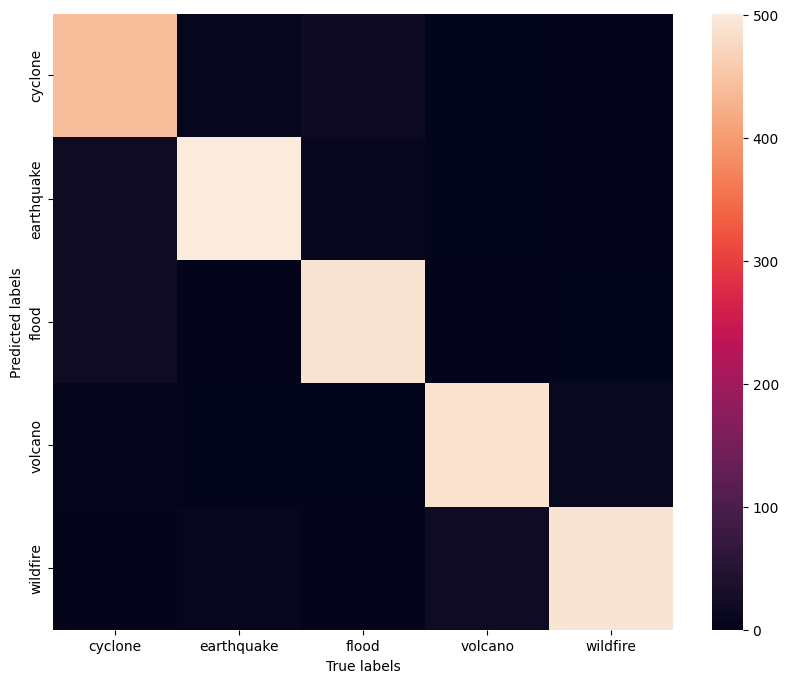

In [26]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

1/1 [==============================] - 2s 2s/step


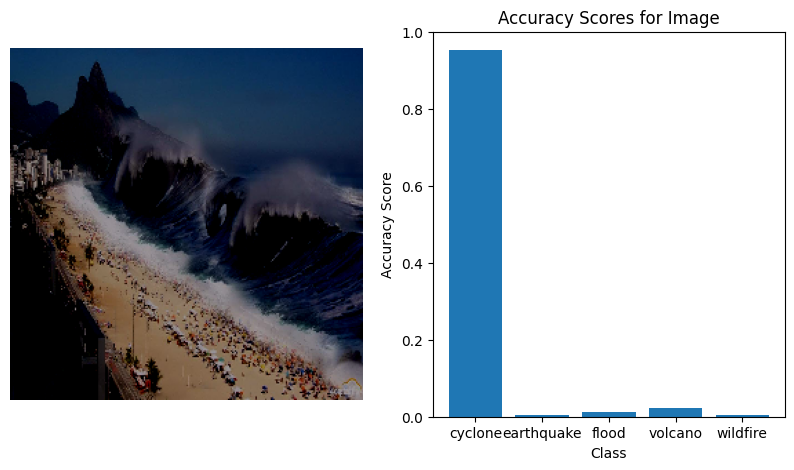

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from PIL import Image

# Assuming your model object is called 'model' and test_gen object is called 'test_gen'
class_labels = ['cyclone','earthquake','flood','volcano', 'wildfire'] # list of class labels

# Get the next batch of images and labels from test_gen
batch = next(test_gen)

# Select the first image in the batch
img = batch[0][0]

# Convert the image from PIL Image to NumPy array
img_arr = img_to_array(img)

# Preprocess the image
img_arr = preprocess_input(img_arr)

# Convert the NumPy array back to a PIL Image object
img = Image.fromarray(np.clip(img_arr + 127.5, 0, 255).astype(np.uint8))

# Predict class probabilities for the image
probs = tl_model.predict(np.expand_dims(img_arr, axis=0))

# Plot the image and accuracy scores for each class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img)
ax1.axis('off')
ax2.bar(np.arange(len(class_labels)), probs[0])
ax2.set_xticks(np.arange(len(class_labels)))
ax2.set_xticklabels(class_labels)
ax2.set_title('Accuracy Scores for Image')
ax2.set_xlabel('Class')
ax2.set_ylabel('Accuracy Score')
plt.show()


# Ensamble 

In [ ]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Load the different model

model1=load_model('resnet_.h5')
model2=load_model('tlft13_model.h5')
model3=load_model('tl_model_gap.h5')
model5=load_model('norm_gap_dense.h5')

In [ ]:
# Initialize empty lists to store predictions from each model
probabilities_model1 = []
probabilities_model2 = []
probabilities_model3 = []
probabilities_model5 = []

N = 2540
ground_truth_labels = test_gen.classes

In [ ]:
# Do the predicton
predictions1 = model1.predict(test_gen, steps=N//32+1)
predictions2 = model2.predict(test_gen, steps=N//32+1)
predictions3 = model3.predict(test_gen, steps=N//32+1)
predictions5 = model5.predict(test_gen, steps=N//32+1)

# Save the predicted label
predicted_labels1 = np.argmax(predictions1, axis=1)
predicted_labels2 = np.argmax(predictions2, axis=1)
predicted_labels3 = np.argmax(predictions3, axis=1)
predicted_labels5 = np.argmax(predictions5, axis=1)

# Print classification report
accuracy = accuracy_score(ground_truth_labels, predicted_labels1)
print(f"Model 1 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels2)
print(f"Model 2 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels3)
print(f"Model 3 Accuracy: {accuracy}")
accuracy = accuracy_score(ground_truth_labels, predicted_labels5)
print(f"Model 5 Accuracy: {accuracy}")

80/80 [==============================] - 68s 804ms/step
Model 1 Accuracy: 0.9409448818897638
Model 2 Accuracy: 0.9405511811023622
Model 3 Accuracy: 0.9173228346456693
Model 4 Accuracy: 0.14921259842519685
Model 5 Accuracy: 0.9287401574803149


In [ ]:
ensemble_predictions = np.argmax(predictions1 + predictions2 + predictions3 + predictions5, axis=1)
majority_vote = np.argmax(np.bincount(ensemble_predictions))

# Print classification report
print("Ensemble Classification Report:")
print(classification_report(ground_truth_labels, ensemble_predictions))

# Print confusion matrix
print("Ensemble Confusion Matrix:")
print(confusion_matrix(ground_truth_labels, ensemble_predictions))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       486
           1       0.94      0.96      0.95       517
           2       0.93      0.96      0.94       520
           3       0.96      0.97      0.96       509
           4       0.96      0.97      0.97       508

    accuracy                           0.95      2540
   macro avg       0.95      0.95      0.95      2540
weighted avg       0.95      0.95      0.95      2540

Ensemble Confusion Matrix:
[[427  22  26   9   2]
 [ 11 496   9   1   0]
 [ 10   8 498   1   3]
 [  0   0   2 492  15]
 [  2   1   0  10 495]]
